In [1]:
%matplotlib inline
from pyqubo import Array, Placeholder, solve_qubo, Constraint, Sum
import matplotlib.pyplot as plt
import networkx as nx

## Graph Coloring Problem

For a given graph $G=(V,E)$ and a number of colors $K$, assign a color for each vertex in $V$ such that no adjacent nodes are colored with the same color. 
QUBO formulation of this problem is represented as

\begin{eqnarray*}
H &=& \alpha H_{A} + H_{B} \\
H_{A} &=& \sum_{i \in V} \left( 1 - \sum_{k = 1}^{K} x_{i,k}\right )^2 \\
H_{B} &=& \sum_{(i, j) \in E} \sum_{k = 1}^{K} x_{i,k} x_{j,k} .
\end{eqnarray*}

$H_{A}$ is a constraint that every vertex is colored with just one color. For each vertex in $V$, when one of the corresponding $K$ binary variables  is 1 and the others are 0, we have $H_{A} = 0$ which is minimum.

$H_{B}$ is a constraint that no adjacent nodes are colored with the same color. For each pair of adjacent vertices (i.e., for each edge in $E$), when there are no adjacents of the same color, we have $H_{B}=0$ which is minimum.

$\alpha$ is a constraint parameter.

In [2]:
def plot_graph(N, E, colors=None):
    G = nx.Graph()
    G.add_nodes_from([n for n in range(N)])
    for (i, j) in E:
        G.add_edge(i, j)
    plt.figure(figsize=(4,4))
    pos = nx.kamada_kawai_layout(G)
    colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']
    if colors:
        nx.draw_networkx(G, pos, node_color=[colorlist[colors[node]] for node in G.nodes], node_size=400, font_weight='bold', font_color='w')
    else:
        nx.draw_networkx(G, pos, node_color=[colorlist[0] for _ in G.nodes], node_size=400, font_weight='bold', font_color='w')
    plt.axis("off")
    plt.show()

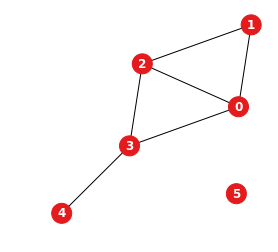

In [3]:
# Given number of vertices (N) and number of colors (K)
N = 6
K = 3

# Given edges
E = {(0, 1), (0, 2), (0, 3), (1, 2), (2, 3), (3, 4)}
plot_graph(N, E)

Prepare a binary vector $x$ with $|V| \times K = 6 \times 3$ dimension. $x[i, k]=1$ represents that vertex $i$ is colored with $k$ (one-hot encoding).

In [4]:
x = Array.create('x', (N, K), 'BINARY')

In [5]:
# Define hamiltonian H_{A}: Constraint that every vertex is colored with just one color
onecolor_const = 0.0
for i in range(N):
    onecolor_const += Constraint((Sum(0, K, lambda j: x[i, j]) - 1)**2, label="onecolor{}".format(i))

In [6]:
# Define hamiltonian H_{A}: Constraint that no adjacent nodes are colored with the same color
adjacent_const = 0.0
for (i, j) in E:
    for k in range(K):
        adjacent_const += Constraint(x[i, k] * x[j, k], label="adjacent({},{})".format(i, j))

In [7]:
# Define hamiltonian H
alpha = Placeholder("alpha")
H = alpha * onecolor_const + adjacent_const

In [8]:
# Compile model
model = H.compile()

# Create QUBO with alpha = 1.0
feed_dict = {'alpha': 1.0}
qubo, offset = model.to_qubo(feed_dict=feed_dict)

In [9]:
# Solve the QUBO and obtain the optimal solution
solution = solve_qubo(qubo)

# Decode solution
decoded_solution, broken, energy = model.decode_solution(solution, vartype="BINARY", feed_dict=feed_dict)
print("number of broken constarint = {}".format(len(broken)))

# Obtain colors of each vertex
colors = [0 for i in range(N)]
for i in range(N):
    for k in range(K):
        if decoded_solution['x'][i][k] == 1:
            colors[i] = k
            break

number of broken constarint = 0


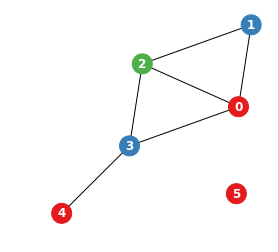

In [10]:
# Plot graph after coloring
plot_graph(N, E, colors)